## Step01. 데이터 수집하기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('import 완료')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


import 완료


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('data 다운 완료')

data 다운 완료


In [3]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [4]:
data.sample(10)

,headlines,text
81337,China's 3rd richest man to sell firm's hotels ...,"Dalian Wanda, founded by China's third richest..."
46471,PM Narendra Modi welcomes Canadian PM Trudeau ...,Prime Minister Narendra Modi welcomed his Cana...
41714,Rohingya man given 2-year jail for getting fak...,A court has awarded a two-year jail term to a ...
10641,Sharing problems with others helps: Karisma on...,"Talking about mental health and depression, Ka..."
86598,5 killed as protesters clash with police over ...,At least five people have reportedly been kill...
74497,'Pinjra Tod Ke' song from Kangana Ranaut's 'Si...,"'Pinjra Tod Ke', a new song from the Kangana R..."
67140,Modi temple with 100-ft statue to be built in ...,A retired engineer and PM Narendra Modi's supp...
65104,Dalai Lama proposes EU-style union for Asian c...,The Dalai Lama has proposed an EU-style union ...
70480,"Man accused of raping, killing, burning 7-year...","A man accused of raping, murdering, and then b..."
18949,Kriti Sanon's Instagram account hacked,Actress Kriti Sanon's Instagram account was ha...


#### 추상적 요약 - text를 본문, headlines를 요약
#### 추출적 요약 - text만 사용

## Step02. 데이터 전처리하기 (추상적 요약)
### (1) 데이터 정리하기

### (1-1) 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
#데이터 중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


41개의 중복 샘플이 있음을 확인

In [6]:
#text 데이터 중복 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


41개의 중복 샘플 제거 완료!

In [7]:
#데이터프레임에 null값의 유무 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


null값이 없음

### (1-2) 텍스트 정규화와 불용어 제거

In [8]:
#it'll은 it will과 같고, mustn't과 must not은 같은 뜻이나 기계가 다른 단어로 인식.
#기계 학습 전에 미리 같은 표현으로 통일 시켜주기 -> 연산량 줄이기 위해 =>텍스트 정규화
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('불용어 제거 완료')

불용어 제거 완료


In [10]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


소문자로 변환

In [11]:
# 전체 Text 데이터에 대한 전처리 
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))


print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
# 전체 headlines 데이터에 대한 전처리
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)
print('빈 값을 가진 샘플을 Null값으로 대체 완료!')

빈 값을 가진 샘플을 Null값으로 대체 완료!


In [14]:
#Null 값 발생 여부 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

### (2) 훈련데이터와 테스트데이터 나누기
### (2-1) 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
표제의 최소 길이 : 1
표제의 최대 길이 : 16
표제의 평균 길이 : 9.299532330215534


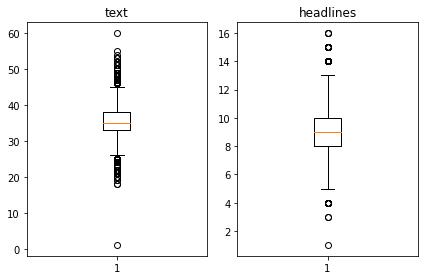

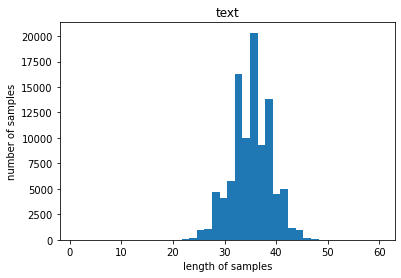

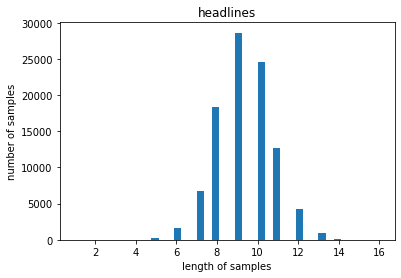

In [15]:
# text와 headlines의 최소, 최대, 평균 길이를 구하기 -> 길이 분포를 시각화 하기
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('표제의 최소 길이 : {}'.format(np.min(headlines_len)))
print('표제의 최대 길이 : {}'.format(np.max(headlines_len)))
print('표제의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
#text의 최대 길이와 headlines의 최대 길이를 임의로 정하기
text_max_len = 40
headlines_max_len = 12
print('임의로 정하기 완료')

임의로 정하기 완료


In [17]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


정해진 길이에 맞춰 자르는 것이 아닌, 정해진 길이보다 길면 해당 샘플 제외하기

In [18]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플 수 :', (len(data)))

전체 샘플 수 : 89775


### (2-2) 시작 토큰과 종료 토큰 추가하기

In [19]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [20]:
#인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('Numpy 타입으로 저장 완료!')

Numpy 타입으로 저장 완료!


### (2-3) 훈련 데이터와 테스트 데이터를 분리

In [21]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 4545 11036 34851 ... 84861 84189 49465]


In [22]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [23]:
# 8:2비율로 훈련 데이터, 테스트 데이터로 분리하기
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17955


In [24]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 71820
훈련 레이블의 개수 : 71820
테스트 데이터의 개수 : 17955
테스트 레이블의 개수 : 17955


### (3) 정수 인코딩

### (3-1) 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [25]:
# 토크나이저 정의
src_tokenizer = Tokenizer() 
# 입력된 데이터로부터 단어 집합 생성
src_tokenizer.fit_on_texts(encoder_input_train) 
print('단어 집합 만들기 완료!')

단어 집합 만들기 완료!


In [26]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65530
등장 빈도가 6번 이하인 희귀 단어의 수: 44577
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20953
단어 집합에서 희귀 단어의 비율: 68.02533190904929
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.6644541574187492


In [27]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)
print('단어 집합의 크기를 20,000으로 제한 완료!')

단어 집합의 크기를 20,000으로 제한 완료!


In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1113, 211, 8564, 10551, 61, 47, 950, 430, 12114, 507, 4005, 201, 18, 148, 750, 452, 4057, 4900, 594, 153, 174, 10551, 233, 2657, 680, 1, 7, 621, 7045, 10551, 950], [430, 35, 96, 412, 15721, 1, 1805, 35, 257, 338, 670, 1064, 9028, 638, 1591, 541, 3038, 35, 90, 20, 170, 332, 5, 172, 8693, 8422, 1140, 1171, 113, 187, 4548, 15721, 2], [701, 22, 66, 1557, 324, 1277, 602, 6033, 315, 173, 1054, 3623, 155, 36, 701, 390, 6571, 1557, 347, 1054, 210, 155, 4, 728, 4671, 310, 179, 1, 1592, 3479, 316, 1054, 155, 1685, 8849, 1767, 4]]


In [29]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('headlines에 동일한 작업하기')

headlines에 동일한 작업하기


In [30]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0 
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28867
등장 빈도가 5번 이하인 희귀 단어의 수: 18921
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9946
단어 집합에서 희귀 단어의 비율: 65.54543250077943
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.8940055254244195


In [31]:
tar_vocab = 9900
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 741, 599, 1335, 8, 8353, 742, 4118, 131, 3749], [1, 2959, 5, 111, 3, 691, 3, 459, 7, 78, 293], [1, 342, 340, 3879, 7, 1205, 205, 5302, 556], [1, 7784, 10, 5076, 7, 1510, 133, 6464, 129, 481, 226], [1, 51, 9, 67, 107, 276, 3750, 465, 3523, 460]]
target
decoder  [[741, 599, 1335, 8, 8353, 742, 4118, 131, 3749, 2], [2959, 5, 111, 3, 691, 3, 459, 7, 78, 293, 2], [342, 340, 3879, 7, 1205, 205, 5302, 556, 2], [7784, 10, 5076, 7, 1510, 133, 6464, 129, 481, 226, 2], [51, 9, 67, 107, 276, 3750, 465, 3523, 460, 2]]


In [32]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 71819
훈련 레이블의 개수 : 71819
테스트 데이터의 개수 : 17955
테스트 레이블의 개수 : 17955


### (3-2) 패딩하기

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('패딩 완료')

패딩 완료


In [34]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

## Step03. 어텐션 메커니즘 사용하기 (추상적 요약)

In [36]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### (1) 모델 훈련하기

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) #일정 조건이 되면 훈련 종료
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
281/281 [==============================] - 168s 566ms/step - loss: 5.6522 - val_loss: 5.2186
Epoch 2/50
281/281 [==============================] - 158s 561ms/step - loss: 5.1118 - val_loss: 4.8617
Epoch 3/50
281/281 [==============================] - 157s 559ms/step - loss: 4.7635 - val_loss: 4.5863
Epoch 4/50
281/281 [==============================] - 161s 573ms/step - loss: 4.4918 - val_loss: 4.3898
Epoch 5/50
281/281 [==============================] - 159s 566ms/step - loss: 4.2836 - val_loss: 4.2582
Epoch 6/50
281/281 [==============================] - 157s 558ms/step - loss: 4.1160 - val_loss: 4.1375
Epoch 7/50
281/281 [==============================] - 156s 555ms/step - loss: 3.9717 - val_loss: 4.0522
Epoch 8/50
281/281 [==============================] - 157s 557ms/step - loss: 3.8425 - val_loss: 3.9799
Epoch 9/50
281/281 [==============================] - 156s 555ms/step - loss: 3.7303 - val_loss: 3.9155
Epoch 10/50
281/281 [==============================] - 156s 556m

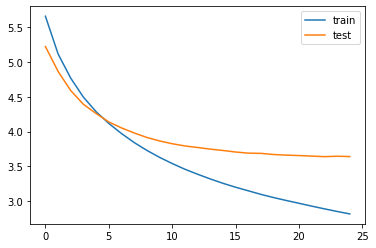

In [38]:
#훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화하기
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### (2) 인퍼런스 모델 구현하기

In [39]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('사전 준비 완료!')

사전 준비 완료!


In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

### (3) 어텐션 메커니즘을 사용하는 출력층을 설계

In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('출력층 설계 완료!')

출력층 설계 완료!


### (4) 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기

In [53]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('함수 만들기 완료!')

함수 만들기 완료!


### (5) 모델 테스트

In [54]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## Step04. 실제 결과와 요약문 비교하기 (추상적 요약)

In [134]:
for i in range(20):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : asked would facebook ceo mark zuckerberg place amid data controversy apple ceo tim cook said would situation also said services track personal lives invading peoples privacy earlier cook said ability know people lives exist 
실제 요약 : would not be in this situation cook on fb data scandal 
예측 요약 :  we are not facebook ceo mark zuckerberg


원문 : meteor shower peak night august august visible india areas away city lights made debris comet swift named appear originate constellation one see meteors per hour night sky 
실제 요약 : meteor shower to peak tonight visible in india 
예측 요약 :  india to host its first ever festival


원문 : kangana ranaut speaking item numbers said obscene times unfair sexist done personally feel banned added kangana said cannot part something toxic us society children 
실제 요약 : do not do item songs as they are obscene sexist kangana 
예측 요약 :  if you are not fair kangana on her


원문 : singer ed sheeran revealed quit using twitter adding go nothing people saying mean th

## Step05. Summa을 이용해서 추출적 요약해보기

### (1) 패키지 설치하기
$ pip list | grep summa

### (2) 데이터 다운로드

In [116]:
import requests
from summa.summarizer import summarize
print('데이터 다운로드 완료!')

데이터 다운로드 완료!


In [117]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('data 다운 완료')

data 다운 완료


In [118]:
data

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [127]:
#추출적 요약은 text만 사용함.
Text=data['text']
Text[1]

"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."

### (3) summarize 사용하기

In [128]:
print('Summary:')
print(summarize(Text[1], ratio=0.5))

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [129]:
print('Summary:')
print(summarize(Text[1], ratio=0.5, split=True))

Summary:
['Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.']


In [130]:
print('Summary:')
print(summarize(Text[1], words=50))

Summary:
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year.
Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins.
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [131]:
Headlines=data['headlines']
Headlines[1]

'Delhi techie wins free food from Swiggy for one year on CRED'

In [133]:
for i in range(20):
    print("원문 :", Text[i])
    print("실제 요약 :", Headlines[i])
    print("예측 요약 :", summarize(text[i], ratio=0.5))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of bill pai

# Step05. 추상적 요약과 추출적 요약 비교해보기(파파고 번역기-제일 첫 원문만 비교 분석)
#### 추상적 요약의 경우,
#### 원문 : asked would facebook ceo mark zuckerberg place amid data controversy apple ceo tim cook said would situation also said services track personal lives invading peoples privacy earlier cook said ability know people lives exist 
#### 실제 요약 : would not be in this situation cook on fb data scandal 
#### 예측 요약 :  we are not facebook ceo mark zuckerberg
#### => 추상적 요약의 예측 요약의 경우, 문법적으로는 완벽하다. 하지만, 페이스북-케임브릿지 애널리티카 정보 유출 사건(fb data scandal)을 다루는 원문의 내용의 핵심 단어가 전혀 들어가지 않았다. -아니, facebook이 들어갔으니 핵심단어가 하나는 들어간건가..?-

#### 추출적 요약의 경우,
#### 원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
#### 실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
#### 예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.
#### => 추출적 요약의 예측 요약의 경우, 문법적으로 완벽하다. 또한, 해당 수업을 듣고 커리어를 발전시켰다는 원문의 내용을 요약도 잘 했다.하지만, 문제는 해당 원문의 마지막 문장을 가져온 것이라서 조금 아쉽다. 

# REPORT
#### 이번에는 정말 시간이 역대급으로 많이 걸린 노드였다!!
#### 전처리 할때도 5~10분 이상 걸린다고 적혀있기는 했지만, lms에서 할때는 '커널이 작동중'과 같은 표시가 떠서 '되고 있구나'싶었는데, 주피터 노트북에서는 작동이 되는지, 안되는지 전혀 알 수가 없어서 처음엔 오류가 난줄 알았다.
#### 모델 훈련하는 부분에서도 시간이 많이 걸렸는데, 모델 훈련을 하는 도중에 인터넷 연결이 오류가 나서 다시 처음부터 돌린다고 정말 눈물을 흘렸던 노드였다. 정말 다행인게 이번 훈련에서는 '특정 조건'에 적합하게 되면 훈련이 멈췄다... 거의 1epochs 당 약 3분 가량 걸렸는데, 50이었으면 150분을 날릴뻔 했다.
#### lms를 따라 열심히 했는데 마지막에 step4에 '(3) summarize 사용하기'부분에서 'ValueError: operation parameter must be str or unicode (str)!'이라는 오류가 나왔다. 검색도 해보고 그랬는데도 오류가 해결이 안되서 text뒤에 [1]이라고 특정한 값을 주니까 오류가 안뜨고 빈칸이 나왔다. 일단 해당 부분의 오류는 해결 된 듯 싶었는데, 빈칸이 나오니 또 머리가 너무 아팠다. ratio 값을 바꾸니 해결되는 문제라서 그나마 다행이었다.